In [1]:
import os
if not os.path.exists("/root/.kaggle/"):
    os.makedirs("/root/.kaggle/")
    with open("/root/.kaggle/kaggle.json", "w+") as f:
      # Write the text to the file
      f.write("""{"username":"isaacblach","key":
        "599d02c69c483f5ead7487a5b0bbae5b"}""")
!chmod 600 /root/.kaggle/kaggle.json
!pip install --upgrade pip
!pip install kaggle pandas matplotlib scikit-learn

# Project Goal and Overview
The goal of this project is to create a Generative Adversarial Network (GAN) to convert images into the monet style.  To do this, I will use the 300 monet images to perform the training.  There are 300 Monets

In [2]:
import kaggle
import zipfile
import tensorflow.keras as keras
from keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
import random
import math


from __future__ import absolute_import, division, print_function
import gzip, pickle
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image

import requests
from os import getcwd
import tarfile

autotune = tf.data.AUTOTUNE
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2024-06-02 17:02:35.612306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Description


In [28]:
tmp_dir = getcwd() + "/kaggle/tmp/"
input_dir = getcwd() + "/kaggle/input/"
if not os.path.exists(getcwd() + "/kaggle"):
    os.makedirs(getcwd() + "/kaggle")
if not os.path.exists(getcwd() + "/kaggle/tmp"):
    os.makedirs(getcwd() + "/kaggle/tmp")
if not os.path.exists(getcwd() + "/kaggle/tmp/images"):
    os.makedirs(getcwd() + "/kaggle/tmp/images")

/Something_of_a_Painter_Myself/kaggle/input/


In [4]:
if not os.path.exists(getcwd() + "kaggle/input/"):
    !kaggle competitions download -c 'gan-getting-started'
    #!mkdir kaggle
    #!mkdir kaggle/input
    #!mkdir kaggle/input/gan-getting-started
    #!unzip -qq gan-getting-started.zip -d kaggle/input/gan-getting-started
    with zipfile.ZipFile('gan-getting-started.zip', 'r') as zip_ref:
        zip_ref.extractall(f"{input_dir}gan-getting-started")

gan-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:

def count_files_in_directory(directory_path):
    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if os.path.isfile(
        os.path.join(directory_path, f))]
    # Count the number of files
    file_count = len(files)
    return file_count
directory_path = f'{input_dir}gan-getting-started/monet_jpg'
file_count = count_files_in_directory(directory_path)
print(f'There are {file_count} Monet Images.')

directory_path = f'{input_dir}gan-getting-started/photo_jpg'
file_count = count_files_in_directory(directory_path)
print(f'There are {file_count} Photo Images.')

There are 300 Monet Images.
There are 7038 Photo Images.


20 Monet Images above 20 Photos


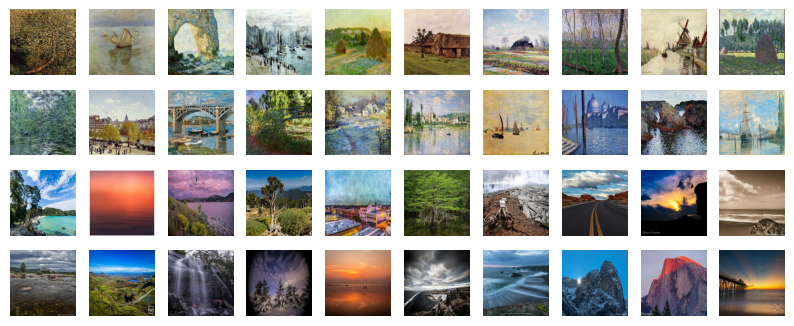

In [6]:
#Generated by Gemini AI but modified to actually work
# Get a list of all the files in the Monet directory
monet_files = os.listdir(f"{input_dir}gan-getting-started/monet_jpg")

# Get a list of all the files in the photo directory
photo_files = os.listdir(f"{input_dir}gan-getting-started/photo_jpg")

# Select 20 random Monet images
random_monet_files = random.sample(monet_files, 20)

# Select 20 random photo images
random_photo_files = random.sample(photo_files, 20)

# Create a 10x2 grid of subplots
fig, axes = plt.subplots(4, 10, figsize=(10, 4))
print("20 Monet Images above 20 Photos")

# Plot the Monet images in the first column

for i, filename in enumerate(random_monet_files):
    img = mpimg.imread(os.path.join(f"{input_dir}/gan-getting-started/monet_jpg", filename))
    axes[math.floor(i%2), math.floor(i/2)].imshow(img)
    axes[math.floor(i%2), math.floor(i/2)].axis('off')

## Plot the photo images in the second column
for i, filename in enumerate(random_photo_files):
    img = mpimg.imread(os.path.join(f"{input_dir}gan-getting-started/photo_jpg", filename))
    axes[math.floor(i%2+2), math.floor(i/2)].imshow(img)
    axes[math.floor(i%2+2), math.floor(i/2)].axis('off')

# Show the plot
plt.show()


# Data Loading and Batch Sizes
In order to perform faster data loading, I chose to load the tfrec files.  I seleted batch sizes to meet GPU memory limitations.

In [7]:
def count_elements(dataset):
    count = 0
    for _ in dataset:
        count += 1
    return count

def decode_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [256, 256])
  return image

def read_tfrecord(example):
  features = {
    'image': tf.io.FixedLenFeature([], tf.string),
  }
  example = tf.io.parse_single_example(example, features)
  image = decode_image(example['image'])
  return image
tfrecord_dir = f"{input_dir}gan-getting-started/monet_tfrec"
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(
    tfrecord_dir) if f.endswith('.tfrec')]
monet_images_dataset = tf.data.TFRecordDataset(
    tfrecord_files).map(read_tfrecord)

tfrecord_dir = f"{input_dir}gan-getting-started/photo_tfrec"
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(
    tfrecord_dir) if f.endswith('.tfrec')]
photo_images_dataset = tf.data.TFRecordDataset(
    tfrecord_files).map(read_tfrecord)
print(monet_images_dataset)



<_MapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>


2024-06-02 17:02:43.358830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22287 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c1:00.0, compute capability: 8.9


In [8]:
# https://keras.io/examples/generative/cyclegan/
# Define the standard image size.
orig_img_size = (256, 256)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0
    #return (img / 127.5)
    #return (img)


def preprocess_train_image(img):
    # Random flip
    print(img)
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [9]:
img_size = 256
image_depth = 3
batch_size = 16
LR = 0.00012
buffer_size = 10000

In [10]:
# prompt: split TFRecordDataset into a train and test set 80/20 split


# Apply the preprocessing operations to the training data


monet_train_dataset = (
    monet_images_dataset.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# Apply the preprocessing operations to the test data
photo_train_dataset = (
    photo_images_dataset.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'Photo Images Count {count_elements(photo_train_dataset)}')
print(f'Monet Images Count {count_elements(monet_train_dataset)}')

#for i, img in enumerate(monet_test_dataset.take(1)):
#    #print(f"Image {i}: {img}")
 #   plt.imshow(img[0] * 127.5 + 127.5)
 #   plt.title(f"Image {i}")
#    plt.axis('off')
#    plt.show()

Tensor("args_0:0", shape=(256, 256, 3), dtype=float32)


2024-06-02 17:02:47.104369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-02 17:02:47.291586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Photo Images Count 440
Monet Images Count 19


#  Starting off the GAN
I used https://keras.io/examples/generative/cyclegan/ as a reference for the initial model build.

In [11]:
# Implementing Instance Normalization due to TFA compatability 
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, gamma_initializer='ones', beta_initializer='zeros'):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
        self.gamma_initializer = gamma_initializer
        self.beta_initializer = beta_initializer

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],),
                                     initializer=self.gamma_initializer,
                                     trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],),
                                    initializer=self.beta_initializer,
                                    trainable=True)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta 

In [12]:


class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [13]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


In [14]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")


In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adversarial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


In [16]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 25 != 0:
          return
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(photo_train_dataset.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = ((prediction * 127.5 + 127.5)*127.5).astype(np.int8)
            img = ((img[0]* 127.5 + 127.5)*127.5).numpy().astype(np.int8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.utils.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()


Epoch 1/50
     19/Unknown 123s 3s/step - D_X_loss: 0.2514 - D_Y_loss: 0.2511 - F_loss: 0.2787 - G_loss: 0.2737  

2024-06-02 17:12:33.484041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:12:33.484132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - D_X_loss: 0.2514 - D_Y_loss: 0.2511 - F_loss: 0.2787 - G_loss: 0.2737 - loss: 0.0000e+00
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - D_X_loss: 0.2505 - D_Y_loss: 0.2508 - F_loss: 0.2742 - G_loss: 0.2779

2024-06-02 17:12:48.553526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:12:48.554247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 787ms/step - D_X_loss: 0.2505 - D_Y_loss: 0.2508 - F_loss: 0.2742 - G_loss: 0.2779 - loss: 0.0000e+00
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2500 - F_loss: 0.2708 - G_loss: 0.2678

2024-06-02 17:13:03.512975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:13:03.513064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 787ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2500 - F_loss: 0.2708 - G_loss: 0.2678 - loss: 0.0000e+00
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - D_X_loss: 0.2497 - D_Y_loss: 0.2499 - F_loss: 0.2690 - G_loss: 0.2667

2024-06-02 17:13:18.627481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:13:18.627690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 790ms/step - D_X_loss: 0.2497 - D_Y_loss: 0.2499 - F_loss: 0.2690 - G_loss: 0.2667 - loss: 0.0000e+00
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - D_X_loss: 0.2502 - D_Y_loss: 0.2501 - F_loss: 0.2691 - G_loss: 0.2672

2024-06-02 17:13:33.586608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:13:33.586669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:13:33.586693: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:13:33.586708: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 785ms/step - D_X_loss: 0.2502 - D_Y_loss: 0.2501 - F_loss: 0.2691 - G_loss: 0.2672 - loss: 0.0000e+00
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - D_X_loss: 0.2503 - D_Y_loss: 0.2500 - F_loss: 0.2695 - G_loss: 0.2662

2024-06-02 17:13:48.594985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:13:48.595134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 796ms/step - D_X_loss: 0.2503 - D_Y_loss: 0.2500 - F_loss: 0.2695 - G_loss: 0.2662 - loss: 0.0000e+00
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - D_X_loss: 0.2509 - D_Y_loss: 0.2500 - F_loss: 0.2708 - G_loss: 0.2668

2024-06-02 17:14:09.038766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:14:09.039072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 785ms/step - D_X_loss: 0.2509 - D_Y_loss: 0.2500 - F_loss: 0.2708 - G_loss: 0.2668 - loss: 0.0000e+00
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - D_X_loss: 0.2499 - D_Y_loss: 0.2500 - F_loss: 0.2678 - G_loss: 0.2653

2024-06-02 17:14:24.028449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:14:24.028526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:14:24.028542: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:14:24.028573: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 788ms/step - D_X_loss: 0.2499 - D_Y_loss: 0.2500 - F_loss: 0.2678 - G_loss: 0.2653 - loss: 0.0000e+00
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2504 - F_loss: 0.2672 - G_loss: 0.2666

2024-06-02 17:14:39.009709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:14:39.009810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 785ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2504 - F_loss: 0.2672 - G_loss: 0.2666 - loss: 0.0000e+00
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2675 - G_loss: 0.2652

2024-06-02 17:14:54.044129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:14:54.044212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 788ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2675 - G_loss: 0.2652 - loss: 0.0000e+00
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - D_X_loss: 0.2499 - D_Y_loss: 0.2500 - F_loss: 0.2665 - G_loss: 0.2647

2024-06-02 17:15:09.041326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:15:09.041462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 785ms/step - D_X_loss: 0.2499 - D_Y_loss: 0.2500 - F_loss: 0.2665 - G_loss: 0.2647 - loss: 0.0000e+00
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2666 - G_loss: 0.2645

2024-06-02 17:15:24.034530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:15:24.034612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:15:24.034635: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:15:24.034656: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 789ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2666 - G_loss: 0.2645 - loss: 0.0000e+00
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2668 - G_loss: 0.2644

2024-06-02 17:15:39.059208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:15:39.059285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:15:39.059306: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:15:39.059324: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 792ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2668 - G_loss: 0.2644 - loss: 0.0000e+00
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2663 - G_loss: 0.2639

2024-06-02 17:15:54.183813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:15:54.183901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 789ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2663 - G_loss: 0.2639 - loss: 0.0000e+00
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - D_X_loss: 0.2502 - D_Y_loss: 0.2501 - F_loss: 0.2666 - G_loss: 0.2637

2024-06-02 17:16:09.212104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:16:09.212227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 787ms/step - D_X_loss: 0.2502 - D_Y_loss: 0.2501 - F_loss: 0.2666 - G_loss: 0.2637 - loss: 0.0000e+00
Epoch 16/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2502 - F_loss: 0.2653 - G_loss: 0.2636

2024-06-02 17:16:24.209294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:16:24.209384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 786ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2502 - F_loss: 0.2653 - G_loss: 0.2636 - loss: 0.0000e+00
Epoch 17/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2500 - F_loss: 0.2661 - G_loss: 0.2633

2024-06-02 17:16:39.203717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:16:39.203853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 792ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2500 - F_loss: 0.2661 - G_loss: 0.2633 - loss: 0.0000e+00
Epoch 18/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2656 - G_loss: 0.2632

2024-06-02 17:16:54.299019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:16:54.299854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 787ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2656 - G_loss: 0.2632 - loss: 0.0000e+00
Epoch 19/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - D_X_loss: 0.2504 - D_Y_loss: 0.2501 - F_loss: 0.2652 - G_loss: 0.2631

2024-06-02 17:17:14.729003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:17:14.729090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 783ms/step - D_X_loss: 0.2504 - D_Y_loss: 0.2501 - F_loss: 0.2652 - G_loss: 0.2631 - loss: 0.0000e+00
Epoch 20/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2500 - F_loss: 0.2645 - G_loss: 0.2630

2024-06-02 17:17:29.601727: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:17:29.601796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:17:29.601817: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:17:29.601827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 782ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2500 - F_loss: 0.2645 - G_loss: 0.2630 - loss: 0.0000e+00
Epoch 21/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2502 - F_loss: 0.2647 - G_loss: 0.2636

2024-06-02 17:17:44.510211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:17:44.510332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 780ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2502 - F_loss: 0.2647 - G_loss: 0.2636 - loss: 0.0000e+00
Epoch 22/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2500 - F_loss: 0.2641 - G_loss: 0.2624

2024-06-02 17:17:59.441025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:17:59.441107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:17:59.441130: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:17:59.441146: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 783ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2500 - F_loss: 0.2641 - G_loss: 0.2624 - loss: 0.0000e+00
Epoch 23/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2638 - G_loss: 0.2621

2024-06-02 17:18:14.379718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:18:14.379823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-02 17:18:14.379882: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 784ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2638 - G_loss: 0.2621 - loss: 0.0000e+00
Epoch 24/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2502 - F_loss: 0.2645 - G_loss: 0.2632

2024-06-02 17:18:29.271329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:18:29.271523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 782ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2502 - F_loss: 0.2645 - G_loss: 0.2632 - loss: 0.0000e+00
Epoch 25/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - D_X_loss: 0.2502 - D_Y_loss: 0.2500 - F_loss: 0.2649 - G_loss: 0.2629

2024-06-02 17:18:44.216450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:18:44.216596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:18:46.346228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


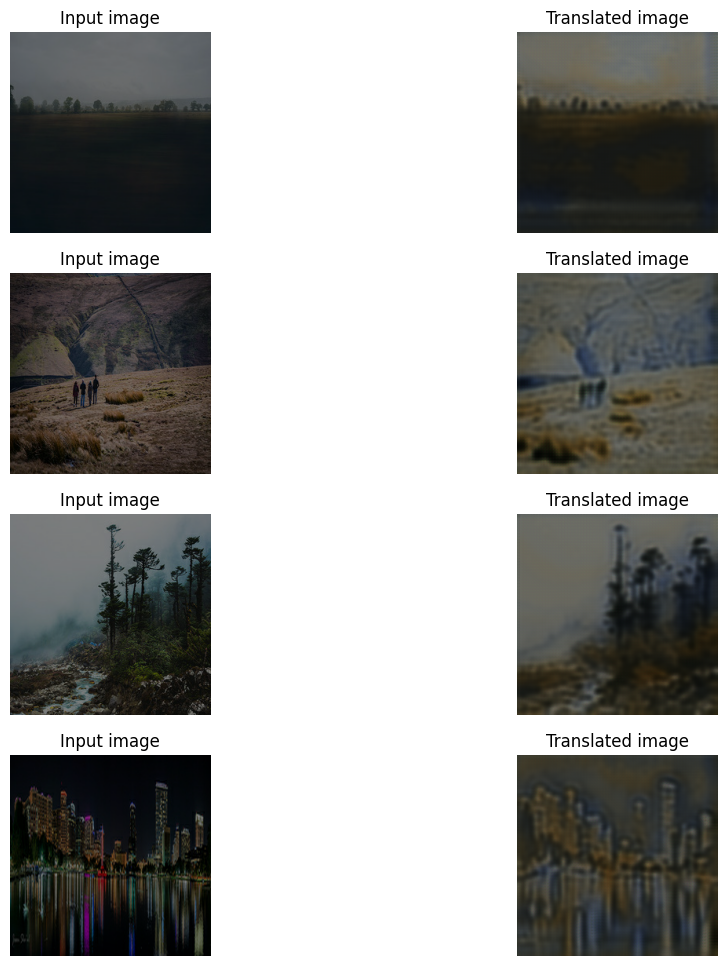

19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 928ms/step - D_X_loss: 0.2502 - D_Y_loss: 0.2500 - F_loss: 0.2649 - G_loss: 0.2629 - loss: 0.0000e+00
Epoch 26/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2500 - F_loss: 0.2638 - G_loss: 0.2621

2024-06-02 17:19:01.723488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:19:01.723578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 783ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2500 - F_loss: 0.2638 - G_loss: 0.2621 - loss: 0.0000e+00
Epoch 27/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2632 - G_loss: 0.2617

2024-06-02 17:19:16.618818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:19:16.618921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 784ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2632 - G_loss: 0.2617 - loss: 0.0000e+00
Epoch 28/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2642 - G_loss: 0.2632

2024-06-02 17:19:31.558403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:19:31.558788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 784ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2642 - G_loss: 0.2632 - loss: 0.0000e+00
Epoch 29/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2641 - G_loss: 0.2618

2024-06-02 17:19:46.477679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:19:46.477748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:19:46.477773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:19:46.477792: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 781ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2641 - G_loss: 0.2618 - loss: 0.0000e+00
Epoch 30/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - D_X_loss: 0.2503 - D_Y_loss: 0.2501 - F_loss: 0.2642 - G_loss: 0.2623

2024-06-02 17:20:01.364693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:20:01.364776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 784ms/step - D_X_loss: 0.2503 - D_Y_loss: 0.2501 - F_loss: 0.2642 - G_loss: 0.2623 - loss: 0.0000e+00
Epoch 31/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2636 - G_loss: 0.2619

2024-06-02 17:20:16.370103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:20:16.370182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:20:16.370207: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:20:16.370220: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 784ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2636 - G_loss: 0.2619 - loss: 0.0000e+00
Epoch 32/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2629 - G_loss: 0.2620

2024-06-02 17:20:31.223302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:20:31.223392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:20:31.223409: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:20:31.223434: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 779ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2629 - G_loss: 0.2620 - loss: 0.0000e+00
Epoch 33/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2634 - G_loss: 0.2618

2024-06-02 17:20:46.100838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:20:46.101128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 780ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2634 - G_loss: 0.2618 - loss: 0.0000e+00
Epoch 34/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2500 - F_loss: 0.2639 - G_loss: 0.2621

2024-06-02 17:21:01.005733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:21:01.005826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 785ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2500 - F_loss: 0.2639 - G_loss: 0.2621 - loss: 0.0000e+00
Epoch 35/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2625 - G_loss: 0.2612

2024-06-02 17:21:15.918160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:21:15.918327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 782ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2625 - G_loss: 0.2612 - loss: 0.0000e+00
Epoch 36/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2500 - F_loss: 0.2621 - G_loss: 0.2615

2024-06-02 17:21:30.817929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:21:30.818091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 779ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2500 - F_loss: 0.2621 - G_loss: 0.2615 - loss: 0.0000e+00
Epoch 37/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2627 - G_loss: 0.2615

2024-06-02 17:21:45.653149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:21:45.653224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:21:45.653252: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:21:45.653266: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 782ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2627 - G_loss: 0.2615 - loss: 0.0000e+00
Epoch 38/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2631 - G_loss: 0.2622

2024-06-02 17:22:00.573814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:22:00.573903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 780ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2631 - G_loss: 0.2622 - loss: 0.0000e+00
Epoch 39/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2500 - F_loss: 0.2634 - G_loss: 0.2618

2024-06-02 17:22:15.461774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:22:15.461867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:22:15.461900: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:22:15.461920: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 792ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2500 - F_loss: 0.2634 - G_loss: 0.2618 - loss: 0.0000e+00
Epoch 40/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2625 - G_loss: 0.2615

2024-06-02 17:22:30.502059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:22:30.502121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:22:30.502137: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:22:30.502149: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 780ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2625 - G_loss: 0.2615 - loss: 0.0000e+00
Epoch 41/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2617 - G_loss: 0.2610

2024-06-02 17:22:45.422577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:22:45.422714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 786ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2617 - G_loss: 0.2610 - loss: 0.0000e+00
Epoch 42/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2626 - G_loss: 0.2613

2024-06-02 17:23:00.457983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:23:00.458068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 785ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2626 - G_loss: 0.2613 - loss: 0.0000e+00
Epoch 43/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2617 - G_loss: 0.2609

2024-06-02 17:23:15.366649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:23:15.366740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:23:15.366764: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:23:15.366781: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 782ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2617 - G_loss: 0.2609 - loss: 0.0000e+00
Epoch 44/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2631 - G_loss: 0.2618

2024-06-02 17:23:30.229409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:23:30.229461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 781ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2631 - G_loss: 0.2618 - loss: 0.0000e+00
Epoch 45/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2622 - G_loss: 0.2612

2024-06-02 17:23:45.111732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:23:45.111862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 780ms/step - D_X_loss: 0.2501 - D_Y_loss: 0.2501 - F_loss: 0.2622 - G_loss: 0.2612 - loss: 0.0000e+00
Epoch 46/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - D_X_loss: 0.2503 - D_Y_loss: 0.2500 - F_loss: 0.2616 - G_loss: 0.2611

2024-06-02 17:23:59.965675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:23:59.965733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-06-02 17:23:59.965754: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 382501015847469679
2024-06-02 17:23:59.965773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5327780392615163062


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 782ms/step - D_X_loss: 0.2503 - D_Y_loss: 0.2500 - F_loss: 0.2616 - G_loss: 0.2611 - loss: 0.0000e+00
Epoch 47/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2628 - G_loss: 0.2611

2024-06-02 17:24:14.938867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:24:14.939000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 786ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2628 - G_loss: 0.2611 - loss: 0.0000e+00
Epoch 48/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2626 - G_loss: 0.2613

2024-06-02 17:24:29.844836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:24:29.844999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 781ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2626 - G_loss: 0.2613 - loss: 0.0000e+00
Epoch 49/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2613 - G_loss: 0.2604

2024-06-02 17:24:44.743545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:24:44.743608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 782ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2613 - G_loss: 0.2604 - loss: 0.0000e+00
Epoch 50/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2617 - G_loss: 0.2611

2024-06-02 17:24:59.632332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-02 17:24:59.632441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-124..127].
2024-06-02 17:25:00.214388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


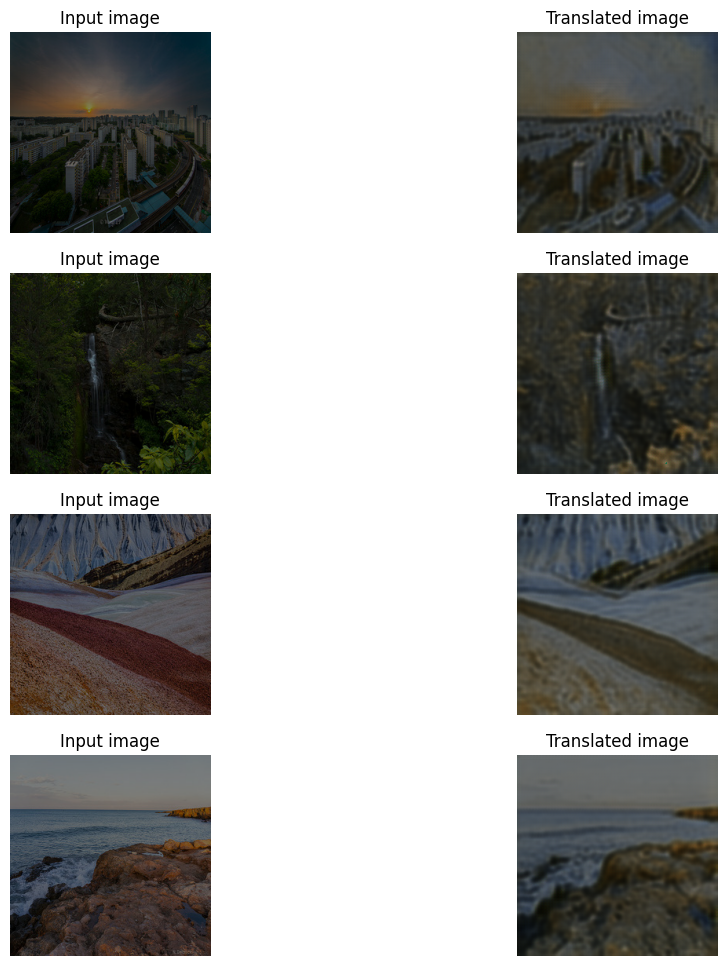

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 843ms/step - D_X_loss: 0.2500 - D_Y_loss: 0.2501 - F_loss: 0.2617 - G_loss: 0.2611 - loss: 0.0000e+00


In [18]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return tf.reduce_mean(fake_loss)

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

# Assuming you have already defined your strategy

# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn
)

plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}.weights.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.

cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_train_dataset, monet_train_dataset)),
    epochs=50,
    callbacks=[plotter, model_checkpoint_callback],
)


# Good Start
The defaults are showing a good starting point.  I'll try to improve on this.  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-128..127].
2024-06-02 17:25:01.743956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


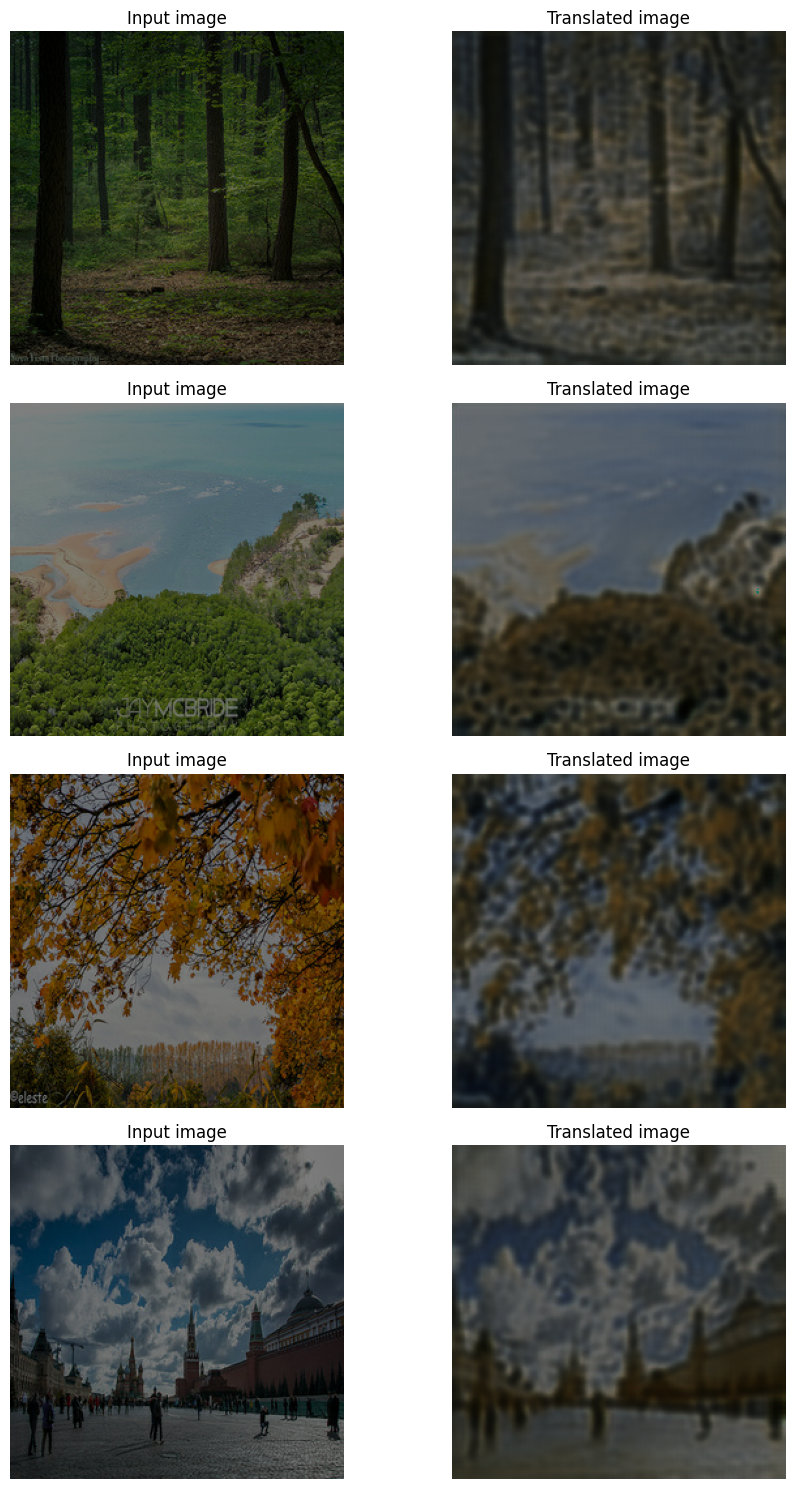

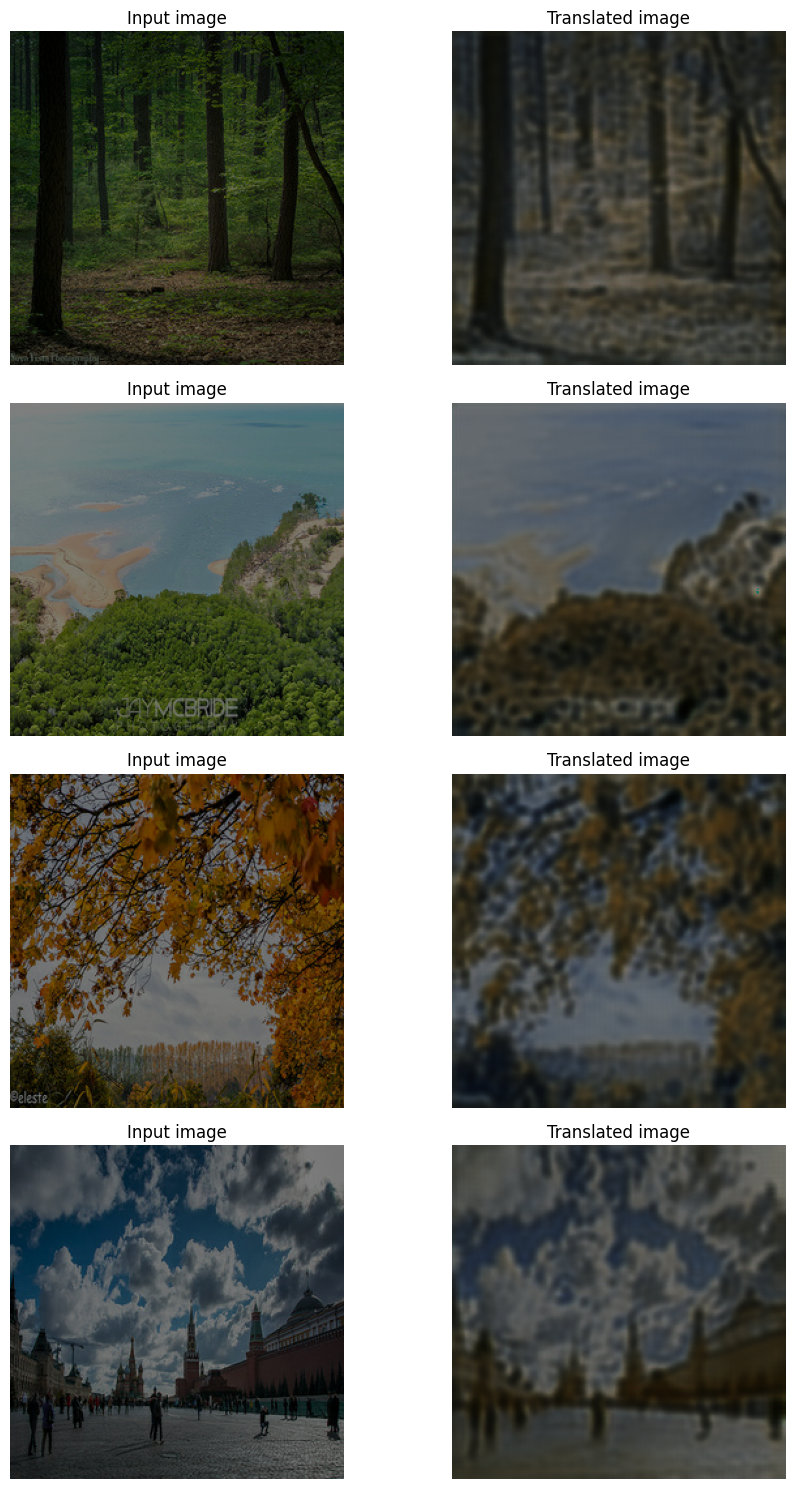

In [19]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(photo_train_dataset.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = ((prediction * 127.5 + 127.5)*127.5).astype(np.int8)
    img = ((img[0]* 127.5 + 127.5)*127.5).numpy().astype(np.int8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.utils.array_to_img(prediction)
    #prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show(False)


In [24]:
def create_images_from_predict(num_images):
    for i, img in enumerate(photo_train_dataset.take(num_images)):
        prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
        prediction = ((prediction * 127.5 + 127.5)*127.5).astype(np.uint8)  # Convert to uint8
        yield prediction
    print(f"{i+1} Photo Images saved")

def create_dataset_from_predictions(num_images):
    dataset = tf.data.Dataset.from_generator(
        lambda: create_images_from_predict(num_images),
        output_signature=tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8)
    )
    return dataset.batch(batch_size)


def create_images_from_dataset():
    img_dir = f"{tmp_dir}/monet_images/"
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
        i = 0
        #print(count_elements(photo_train_dataset))
        for i, img in enumerate(monet_train_dataset):
            prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
            prediction = ((prediction * 127.5 + 127.5)*127.5).astype(np.uint8)  # Convert to uint8
            prediction = keras.utils.array_to_img(prediction)
            #print(prediction.format)
            prediction.save(
                f"{img_dir}/generated_img_{i}.png".format(i=i)
            )
            im = Image.open(str(f"{img_dir}/generated_img_{i}.png".format(i=i)))
            #print(im.format)
            #print(f"Saved {img_dir}predicted_img_{i}.png")
        print(f"{i+1} Monet Images saved")
create_images_from_predict(256)
#create_images_from_dataset()

<generator object create_images_from_predict at 0x7fc2844c7d30>

# Scoring Code
Copied from Kaggle.  Updated by ChatGPT for TensorFlow 2.x compatability.

In [ ]:
inception_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                    weights="imagenet", 
                                                    pooling='avg')

# Function to compute embeddings
def compute_embeddings(dataloader, count):
    image_embeddings = []
    for _ in tqdm(range(count)):
        images = next(iter(dataloader))
        embeddings = inception_model.predict(images)
        image_embeddings.extend(embeddings)
    return image_embeddings
    
# Number of images to generate and process
num_images = 10000
count = math.ceil(num_images / batch_size)

# Create dataset from predictions
generated_images_dataset = create_dataset_from_predictions(num_images)

# Compute embeddings for generated images
generated_image_embeddings = compute_embeddings(generated_images_dataset, count)


# Define the count based on the number of images and batch size
num_images = count_elements(monet_train_dataset)
count = math.ceil(num_images / batch_size)


# Compute embeddings for real images
real_image_embeddings = compute_embeddings(monet_train_dataset, count)

real_image_embeddings_array = np.array(real_image_embeddings)
print(real_image_embeddings_array.shape)
generated_image_embeddings_array = np.array(generated_image_embeddings)

# Display the first image from the real and predicted datasets
# Function to display an image from the dataset
def display_image(image_tensor, title):
    plt.imshow(image_tensor)
    plt.title(title)
    plt.axis('off')
    plt.show()
print("First image from the real dataset:")
print(real_image_embeddings_array[0].shape)
display_image(real_image_embeddings_array[0], "Real Image")

print("First image from the predicted dataset:")
display_image(generated_image_embeddings_array[0], "Predicted Image")

# Calculate FID score
def calculate_fid(real_image_embeddings_array, generated_image_embeddings_array):
    # calculate mean and covariance statistics
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fid = calculate_fid(real_image_embeddings, generated_image_embeddings)
print(fid)

  0%|          | 0/625 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


  0%|          | 1/625 [00:05<54:02,  5.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  0%|          | 2/625 [00:06<31:56,  3.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  0%|          | 3/625 [00:08<25:11,  2.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 4/625 [00:10<21:38,  2.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  1%|          | 5/625 [00:11<19:48,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


  1%|          | 6/625 [00:13<18:52,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 7/625 [00:14<18:04,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  1%|▏         | 8/625 [00:16<17:26,  1.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|▏         | 9/625 [00:18<16:58,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 10/625 [00:19<16:40,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  2%|▏         | 11/625 [00:21<16:44,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  2%|▏         | 12/625 [00:22<16:38,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 13/625 [00:24<16:30,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  2%|▏         | 14/625 [00:26<16:32,  1.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  2%|▏         | 15/625 [00:28<19:56,  1.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  3%|▎         | 16/625 [00:30<18:52,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|▎         | 17/625 [00:32<18:00,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|▎         | 18/625 [00:33<17:31,  1.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 19/625 [00:35<17:03,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  3%|▎         | 20/625 [00:36<16:53,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 21/625 [00:38<16:40,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  4%|▎         | 22/625 [00:40<16:29,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▎         | 23/625 [00:41<16:29,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  4%|▍         | 24/625 [00:43<16:28,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 25/625 [00:45<16:22,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


  4%|▍         | 26/625 [00:46<16:32,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▍         | 27/625 [00:48<16:19,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  4%|▍         | 28/625 [00:49<16:21,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


  5%|▍         | 29/625 [00:51<16:13,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  5%|▍         | 30/625 [00:53<16:22,  1.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


  5%|▍         | 31/625 [00:55<16:46,  1.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  5%|▌         | 32/625 [00:56<16:37,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 33/625 [00:58<16:20,  1.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▌         | 34/625 [00:59<16:12,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|▌         | 35/625 [01:01<16:08,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  6%|▌         | 36/625 [01:03<16:26,  1.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  6%|▌         | 37/625 [01:04<16:15,  1.66s/it]

In [ ]:
!git add .
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"
!git commit -m "no"
!git push